## 2nd assignment (text classification)
- #### Dimitris Georgiou - DS3517004
- #### Stratos Gounidellis - DS3517005
- #### Natasa Farmaki - DS3517018

In [1]:
# import necessary libraries

import csv
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from matplotlib.font_manager import FontProperties
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from scipy.sparse import vstack, hstack
from scipy import sparse
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.naive_bayes import GaussianNB
%matplotlib inline


The Enron Corpus is a large database of over 600,000 emails generated by 158 employees of the Enron Corporation and acquired by the Federal Energy Regulatory Commission during its investigation after the company's collapse.

The Enron data was originally collected at Enron Corporation headquarters in Houston during two weeks in May 2002 by Joe Bartling, a litigation support and data analysis contractor working for Aspen Systems, now Lockheed Martin, whom the Federal Energy Regulatory Commission (FERC) had hired to preserve and collect the vast amounts of data in the wake of the Enron Bankruptcy in December 2001. In addition to the Enron employee emails, all of Enron's enterprise database systems, hosted in Oracle databases on Sun Microsystems servers, were also captured and preserved including its online energy trading platform, EnronOnline.

In the current subset we used a subset of the above dataset with 5172 pre-processed emails (3672 legitimate emails and 1500 spam emails). That subset can be found [here](http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/enron1.tar.gz).

In [2]:
ham_path = "enron1\\ham"
spam_path="enron1\\spam"
onlyfiles = [f for f in listdir(ham_path) if isfile(join(ham_path, f))]
messages = pd.DataFrame(columns=["label", "message"])
for mail in onlyfiles:
    file = open(ham_path + "\\" + mail, "r") 
    messages = messages.append({"label": 'ham' , "message": file.read()},
                               ignore_index=True)
    
print ("Legitimate emails:", len(onlyfiles))
        
onlyfiles = [f for f in listdir(spam_path) if isfile(join(spam_path, f))]
for mail in onlyfiles:
    file = open(spam_path + "\\" + mail, "r", errors='ignore') 
    messages = messages.append({"label": 'spam' , "message": file.read()},
                               ignore_index=True)
    
print ("Spam emails:", len(onlyfiles))


Legitimate emails: 3672
Spam emails: 1500


Split the dataset into training and test set with test size equal to the thirty percent (30%) of the initial dataset (3620 training data and 1552 test data). Additionally, the label is encoded with values 0 and 1, with 0 standing for "ham" and 1 standing for "spam".

In [3]:
msg_train, msg_test, label_train, label_test = train_test_split(messages['message'],
                                                                messages['label'],
                                                                test_size=0.3,
                                                                random_state=2018)

le = preprocessing.LabelEncoder()
le.fit(label_train)
label_train = le.transform(label_train)
label_test = le.transform(label_test)


Convert the collection of the to a sparse matrix of TF-IDF features. We use unigrams, bigrams and trigrams. When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold, i.e. 10 in our case. This value is also called cut-off in the literature. Apart from the TF-IDF features we utilize also the length of each email as a feature.


In [4]:
# smooth_idf=False -> SOS not working properly
vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words='english',
                             min_df=10)

X_train = vectorizer.fit_transform(msg_train)
X_test = vectorizer.transform(msg_test)

msg_train_len = [len(message) for message in msg_train]
msg_test_len = [len(message) for message in msg_test]
X_train = hstack((X_train, np.array(msg_train_len)[:, None])).A
X_test = hstack((X_test, np.array(msg_test_len)[:, None])).A


Normalize the features to be between -1 and 1. This is a significant pre-processing step especially for the SVD method following later.

In [5]:
normalizer = MinMaxScaler(feature_range=(-1.0, 1.0))
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)


Determine the most significant features after performing Random Forest Classifier on the data. Keep the 20 most important features, according to their significance derived from the algorithm. In addition, select features according to the k highest scores. As score is used the f_classif. This is a scoring function to be used in a feature seletion procedure, not a free standing feature selection procedure.

In [6]:
clfRandomForest = RandomForestClassifier(random_state=2018)
clfRandomForest.fit(X_train, label_train)
importantFeat = pd.DataFrame(clfRandomForest.feature_importances_,
                             index=np.arange(X_train.shape[1]), columns=["Importance"])
top10Random = importantFeat.sort_values("Importance",
                                        ascending=False).head(20).index

X_score = SelectKBest(score_func=f_classif, k='all').fit(X_train, label_train)
feature_scores = pd.DataFrame({
        'feature': np.arange(X_train.shape[1]),
        'score': X_score.scores_
})
top10KBest = feature_scores.sort_values('score',
                                        ascending=False).head(20)['feature'].values

topFeatures_ind = set(np.hstack([top10Random, top10KBest]))
topFeatures_train = X_train[:, list(topFeatures_ind)]
topFeatures_test = X_test[:, list(topFeatures_ind)]


Moreover, we apply SVD on the TF-IDF matrix. More specifically, in linear algebra, the singular-value decomposition (SVD) is a factorization of a real or complex matrix. It is the generalization of the eigendecomposition of a positive semidefinite normal matrix (for example, a symmetric matrix with positive eigenvalues) to any m X n matrix via an extension of the polar decomposition. It has many useful applications in signal processing and statistics. We select the number of components to keep based on the variance explained. Indeed, we keep enough components to explain at least 80% of the variance.

In [7]:
def select_features_svd(train_X, test_X, k):
    selector = TruncatedSVD(n_components=k, random_state=1989)
    selector.fit(train_X)
    train_X = selector.transform(train_X)
    test_X = selector.transform(test_X)
    return train_X, test_X


def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0

    # Set initial number of features
    n_components = 0

    # For the explained variance of each feature:
    for explained_variance in var_ratio:

        # Add the explained variance to the total
        total_variance += explained_variance

        # Add one to the number of components
        n_components += 1

        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break

    # Return the number of components
    print("Total variance:", total_variance)
    print("Number of components:", n_components)
    return n_components


In [8]:
tsvd = TruncatedSVD(n_components=1000, random_state=2018)
X_tsvd = tsvd.fit(X_train)
tsvd_var_ratios = tsvd.explained_variance_ratio_

k = select_n_components(tsvd_var_ratios, 0.80)

X_train, X_test = select_features_svd(X_train, X_test, k)


Total variance: 0.800075595578
Number of components: 684


Combine the SVD components with the features selected with the two methods mentioned above. The final number of features used to predict the label of the email is 715.

In [9]:
X_train = np.hstack((np.array(X_train), topFeatures_train))
X_test = np.hstack((np.array(X_test), topFeatures_test))

X_train = sparse.csr_matrix(X_train)
X_test = sparse.csr_matrix(X_test)

print(X_train.shape)
print(X_test.shape)


(3620, 715)
(1552, 715)


### Helper functions

Compute Receiver operating characteristic. In statistics, a receiver operating characteristic curve, i.e. ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.
The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. 

In [10]:
def roc_curve_plot(label_test, predictions):
    false_positive_rate, recall, thresholds = roc_curve(label_test,
                                                        predictions)
    roc_auc = auc(false_positive_rate, recall)
    plt.figure()
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out')
    plt.show()


Compute confusion matrix to evaluate the accuracy of a classification. In the field of machine learning and specifically the problem of statistical classification, a confusion matrix, also known as an error matrix,is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one (in unsupervised learning it is usually called a matching matrix). Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class (or vice versa).

In [11]:
def conf_matrix(label_test, predictions):
    confusion = confusion_matrix(label_test, predictions)
    print(confusion)
    plt.matshow(confusion)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


Compute metrics (f1-score & accuracy) for the classifier as it is trained in an increasing number of training data. The metrics will be later used to draw the learning curves. 

In [12]:
def benchmark(clf, train_X, train_y, test_X, test_y):
    clf.fit(train_X, train_y)
    pred = clf.predict(test_X)
    f1 = metrics.f1_score(test_y, pred, average='weighted')
    accuracy = metrics.accuracy_score(test_y, pred)
    result = {'f1' : f1, 'accuracy' : accuracy, 'train size' : len(train_y),
              'test size' : len(test_y), 'predictions': pred }
    return result


Compute the metrics for all the training phases of the classifier. Both accuracy and f1-score are used as metrics because the dataset is characterised by the class imbalance problem, and f1-score takes into account also precision and recall, which can be more valid metrics for our case.

In [13]:
def calc_metrics(clf, X_train, label_train, X_test, label_test):
    train_x_s_s, train_y_s_s = X_train, label_train
    test_x_s_s, test_y_s_s = X_test, label_test
    
    results = {}
    results['train_size'] = []
    results['on_test_acc'] = []
    results['on_train_acc'] = []

    results['on_test_f1'] = []
    results['on_train_f1'] = []

    for i in range(1, 11):
        if(i==10):
            train_x_part = train_x_s_s
            train_y_part = train_y_s_s
        else:
            to = int(i*(train_x_s_s.shape[0]/10))
            train_x_part = train_x_s_s[0: to, :]
            train_y_part = train_y_s_s[0: to]

        print(train_x_part.shape)
        results['train_size'].append(train_x_part.shape[0])

        result = benchmark(clf, train_x_part, train_y_part, 
                           test_x_s_s, test_y_s_s)

        results['on_test_acc'].append(result['accuracy'])
        results['on_test_f1'].append(result['f1'])
        result = benchmark(clf, train_x_part, train_y_part, 
                           train_x_part, train_y_part)

        results['on_train_acc'].append(result['accuracy'])
        results['on_train_f1'].append(result['f1'])
    return results


Plot the learning curves. A learning curve conventionally depicts improvement in performance on the vertical axis when there are changes in another parameter (on the horizontal axis), such as training set size (in machine learning). In our case, on the vertical axis the learning curves depict f1-score/accuracy and on the horizontal axis the number of the training data.

In [14]:
def learning_curves(results, metric, method):
    fontP = FontProperties()
    fontP.set_size('small')
    fig = plt.figure()
    fig.suptitle('Learning Curves - ' + method, fontsize=17)
    ax = fig.add_subplot(111)
    ax.axis([300, 3800, 0.8, 1.1])
    if method == "K-Nearest-Neighbors":
        ax.axis([300, 3800, 0.4, 1.1])
    if metric == "accuracy":
        line_up, = ax.plot(results['train_size'], results['on_train_acc'],
                           'o-', label='Accuracy on Train')
        line_down, = ax.plot(results['train_size'], results['on_test_acc'],
                             'o-', label='Accuracy on Test')
        plt.ylabel('Accuracy', fontsize=13)

        plt.legend([line_up, line_down], ['Accuracy on Train', 'Accuracy on Test'],
                   prop=fontP)
    else:
        line_up, = ax.plot(results['train_size'], results['on_train_f1'],
                           'o-', label='F1-score on Train')
        line_down, = ax.plot(results['train_size'], results['on_test_f1'],
                             'o-', label='F1-score on Test')
        plt.ylabel('F1-score', fontsize=13)
        plt.legend([line_up, line_down], ['F1-score on Train', 'F1-score on Test'],
                   prop=fontP)

    plt.xlabel('Number of training instances', fontsize=13)
    plt.grid(True)


Plot precision-recall curve. The trade-off between precision and recall can be observed using the precision-recall curve, and an appropriate balance between the two obtained. Depending on the requirement (high precision at the cost of recall, or high recall with lower precision), an appropriate algorithm can be chosen.

In [15]:
def prec_rec_curve(X_test, label_test, type_classifier, classifier):

    if type_classifier == "decision":
        y_score = classifier.decision_function(X_test)
    else:
        y_score = classifier.predict_proba(X_test)[:, 1]

    average_precision = average_precision_score(label_test, y_score)

    precision, recall, thresholds = precision_recall_curve(label_test, y_score)

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    plt.show()


### Classifiers 

### 1.  Baseline Classifier

To get a clear picture of a classifier’s performance, it is common to compare its accuracy or error rate to those of a simplistic “baseline” approach. In our case, we used the most simple classifier. As stated above the dataset is imbalanced, which means that the legitimate messages are far more than the spam messages. So the most simple classifier would just classify all emails as legitimate. In other words, legitimate messages are (correctly) never blocked, and spam messages (mistakenly) always pass.

Additionally, since the dataset is imbalanced we should employ an accurate and reliable metric to compare each of the implemented classifiers with the baseline classifier. Thus, we calculated the weighted versions of accuracy and error for the baseline classifier giving more weight to the number of the legitimate emails. In our case, we set the weight to two (2).


In [16]:
nspam = len(label_test[label_test == 1])
nham = len(label_test[label_test == 0])

l = 2
wb_accuracy = (l * nham) / ((l * nham) + nspam)
wb_error = nspam / ((l * nham) + nspam)

print ("Accuracy (baseline classifier):", wb_accuracy)
print ("Error (baseline classifier):", wb_error)

Accuracy (baseline classifier): 0.8352720450281426
Error (baseline classifier): 0.1647279549718574


### 2. Logistic Regression

Build a logistic regression model. Use grid search and cross validation in order to calculate the best hyperparameters for the classifier.

In [17]:
# Create logistic regression
logistic = LogisticRegression()

# Create regularization hyperparameter space
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Create hyperparameter options
hyperparameters = dict(C=C)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)

classifier = clf.fit(X_train, label_train)


Evaluate accuracy, precision, recall and f1-score of the logistic score by cross-validation.

In [18]:
scores = cross_val_score(classifier, X_train, label_train, cv=5)
print ('Accuracy', np.mean(scores), scores)
precisions = cross_val_score(classifier, X_train, label_train, cv=5,
                             scoring='precision')
print ('Precision', np.mean(precisions), precisions)
recalls = cross_val_score(classifier, X_train, label_train, cv=5,
                          scoring='recall')
print ('Recall', np.mean(recalls), recalls)
f1s = cross_val_score(classifier, X_train, label_train, cv=5, scoring='f1')
print ('F1', np.mean(f1s), f1s)

predictions = classifier.predict(X_test)


Accuracy 0.978172580063 [ 0.98344828  0.9820442   0.97790055  0.97928177  0.96818811]
Precision 0.951441872455 [ 0.97183099  0.95022624  0.95794393  0.94570136  0.93150685]
Recall 0.975498272655 [ 0.97183099  0.99056604  0.96698113  0.98584906  0.96226415]
F1 0.963248580861 [ 0.97183099  0.96997691  0.96244131  0.96535797  0.94663573]


Calculate the weighted versions of accuracy and error for the logistic regression classifier giving more weight to the number of the legitimate emails, the false postive (legitimate -> spam) and the true negative (legitimate -> legitimate). In our case, we set the weight to two (2), as state also above.

Calculate the the ratio of the weighted error of the baseline classifier to the weighted error of the logistic regression classifier. This is the total cost ratio (TCR). The higher TCR, the better our classifier is in comparison to the baseline classifier. Logistic regression classifier seems to perform quite well as far as TCR is concerned.

In [19]:
tn, fp, fn, tp = confusion_matrix(label_test, predictions).ravel()
wlog_accuracy = ((l * tn) + tp) / ((l * nham) + nspam)

wlog_error = ((l * fp) + fn) / ((l * nham) + nspam)
tcr = wb_error / wlog_error
print("Total cost ratio - Logistic Regression vs. baseline classifier:", tcr)


Total cost ratio - Logistic Regression vs. baseline classifier: 10.2093023256


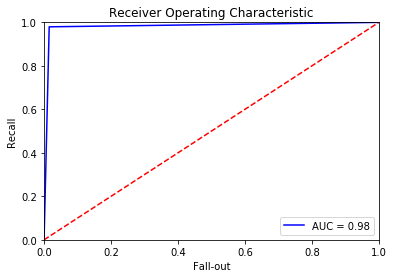

In [20]:
roc_curve_plot(label_test, predictions)


[[1096   17]
 [   9  430]]


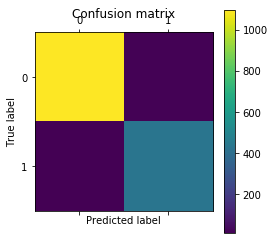

In [21]:
conf_matrix(label_test, predictions)


In [22]:
results = calc_metrics(clf, X_train, label_train, X_test, label_test)


(362, 715)
(724, 715)
(1086, 715)
(1448, 715)
(1810, 715)
(2172, 715)
(2534, 715)
(2896, 715)
(3258, 715)
(3620, 715)


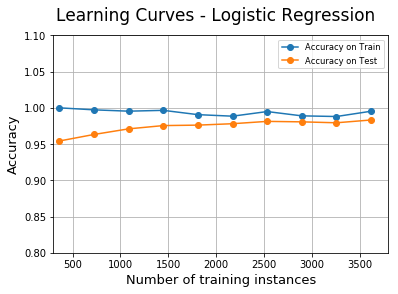

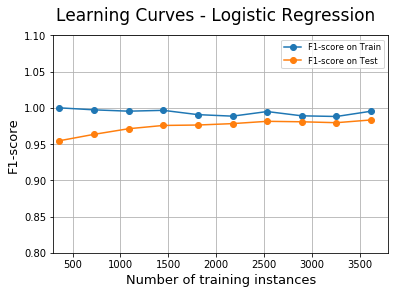

In [23]:
learning_curves(results, "accuracy", "Logistic Regression")
learning_curves(results, "f1-score", "Logistic Regression")


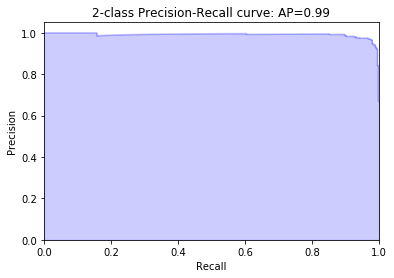

In [24]:
prec_rec_curve(X_test, label_test, "decision", clf)


### 3. Naive Bayes 

In [25]:
clf = GaussianNB()
classifier = clf.fit(X_train.toarray(), label_train)

scores = cross_val_score(classifier, X_train.toarray(), label_train, cv=5)
print ("Accuracy", np.mean(scores), scores)
precisions = cross_val_score(classifier, X_train.toarray(), label_train, cv=5,
                             scoring='precision')
print ('Precision', np.mean(precisions), precisions)
recalls = cross_val_score(classifier, X_train.toarray(), label_train, cv=5,
                          scoring='recall')
print ('Recall', np.mean(recalls), recalls)
f1s = cross_val_score(classifier, X_train.toarray(), label_train, cv=5, scoring='f1')
print ('F1', np.mean(f1s), f1s)

predictions = classifier.predict(X_test.toarray())

Accuracy 0.897235580669 [ 0.89793103  0.89226519  0.89364641  0.91160221  0.89073306]
Precision 0.748190167133 [ 0.75090253  0.73591549  0.74907749  0.77007299  0.73498233]
Recall 0.97926742847 [ 0.97652582  0.98584906  0.95754717  0.99528302  0.98113208]
F1 0.848203607014 [ 0.84897959  0.84274194  0.84057971  0.86831276  0.84040404]


Calculate the weighted versions of accuracy and error for the Naive Bayes classifier giving more weight to the number of the legitimate emails, the false postive (legitimate -> spam) and the true negative (legitimate -> legitimate). In our case, we set the weight to two (2), as state also above.

Calculate the the ratio of the weighted error of the baseline classifier to the weighted error of the Naive Bayes classifier. This is the total cost ratio (TCR). The higher TCR, the better our classifier is in comparison to the baseline classifier. Naive Bayes classifier does not seem to perform well as far as TCR is concerned.

In [26]:
tn, fp, fn, tp = confusion_matrix(label_test, predictions).ravel()
wgnb_accuracy = ((l * tn) + tp)/((l * nham) + nspam)

wgnb_error = ((l * fp) + fn) / ((l * nham) + nspam)
tcr = wb_error / wgnb_error
print("Total cost ratio - Naive Bayes vs. baseline classifier:", tcr)


Total cost ratio - Naive Bayes vs. baseline classifier:: 1.44884488449


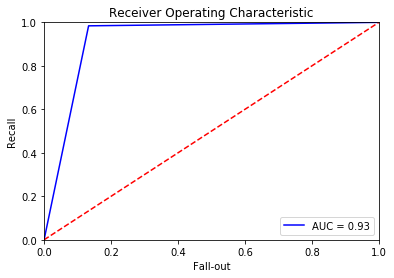

In [27]:
roc_curve_plot(label_test, predictions)

[[965 148]
 [  7 432]]


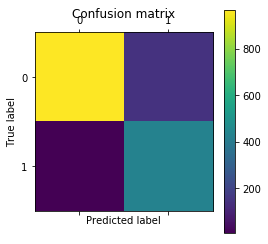

In [28]:
conf_matrix(label_test, predictions)


In [29]:
results = calc_metrics(clf, X_train.toarray(), label_train, X_test.toarray(), label_test)


(362, 715)
(724, 715)
(1086, 715)
(1448, 715)
(1810, 715)
(2172, 715)
(2534, 715)
(2896, 715)
(3258, 715)
(3620, 715)


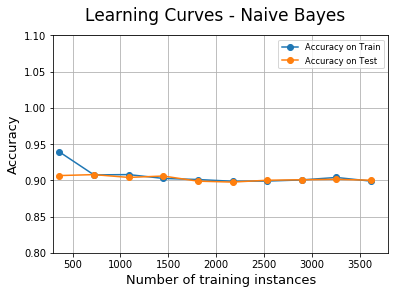

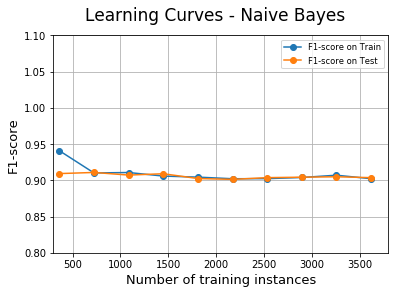

In [30]:
learning_curves(results, "accuracy", "Naive Bayes")
learning_curves(results, "f1-score", "Naive Bayes")


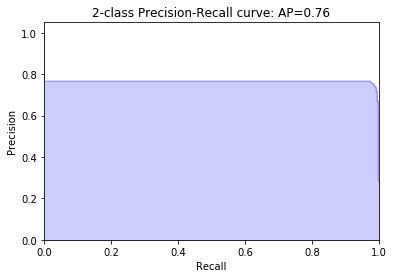

In [31]:
prec_rec_curve(X_test.toarray(), label_test, "proba", clf)


### 4. k-Nearest Neighbors

In [35]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()

# Create regularization hyperparameter space
n_neighbors = [3, 5, 7]

# Create hyperparameter options
hyperparameters = dict(n_neighbors=n_neighbors)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(neigh, hyperparameters, cv=5, verbose=0)

classifier = clf.fit(X_train, label_train)


In [36]:
scores = cross_val_score(classifier, X_train, label_train, cv=5, n_jobs=-1)
print ("Accuracy", np.mean(scores), scores)
precisions = cross_val_score(classifier, X_train, label_train, cv=5, n_jobs=-1,
                             scoring='precision')
print ('Precision', np.mean(precisions), precisions)
recalls = cross_val_score(classifier, X_train, label_train, cv=5, n_jobs=-1,
                          scoring='recall')
print ('Recall', np.mean(recalls), recalls)
f1s = cross_val_score(classifier, X_train, label_train, cv=5, n_jobs=-1, scoring='f1')
print ('F1', np.mean(f1s), f1s)

predictions = classifier.predict(X_test)


Accuracy 0.816572924514 [ 0.8262069   0.79005525  0.82458564  0.8218232   0.82019364]
Precision 0.617076932675 [ 0.62908012  0.58426966  0.62686567  0.6231454   0.62202381]
Recall 0.988683674373 [ 0.99530516  0.98113208  0.99056604  0.99056604  0.98584906]
F1 0.759785799879 [ 0.77090909  0.73239437  0.7678245   0.76502732  0.76277372]


Calculate the weighted versions of accuracy and error for the knn classifier giving more weight to the number of the legitimate emails, the false postive (legitimate -> spam) and the true negative (legitimate -> legitimate). In our case, we set the weight to two (2), as state also above.

Calculate the the ratio of the weighted error of the baseline classifier to the weighted error of the knn classifier. This is the total cost ratio (TCR). The higher TCR, the better our classifier is in comparison to the baseline classifier. knn classifier does not seem to perform well as far as TCR is concerned.

In [38]:
tn, fp, fn, tp = confusion_matrix(label_test, predictions).ravel()
wneigh_accuracy = ((l * tn) + tp)/((l * nham) + nspam)

wneigh_error = ((l * fp) + fn) / ((l * nham) + nspam)
tcr = wb_error / wneigh_error
print("Total cost ratio - knn vs. baseline classifier:", tcr)


Total cost ratio - knn vs. baseline classifier: 0.67125382263


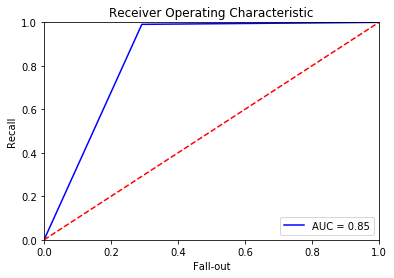

In [41]:
roc_curve_plot(label_test, predictions)


[[788 325]
 [  4 435]]


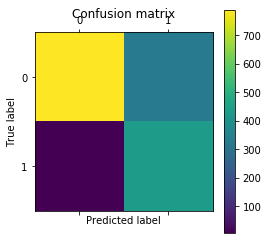

In [42]:
conf_matrix(label_test, predictions)


In [43]:
results = calc_metrics(clf, X_train, label_train, X_test, label_test)


(362, 715)
(724, 715)
(1086, 715)
(1448, 715)
(1810, 715)
(2172, 715)
(2534, 715)
(2896, 715)
(3258, 715)
(3620, 715)


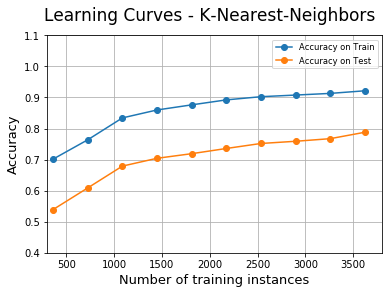

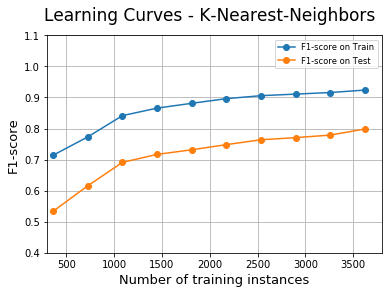

In [44]:
learning_curves(results, "accuracy", "K-Nearest-Neighbors")
learning_curves(results, "f1-score", "K-Nearest-Neighbors")


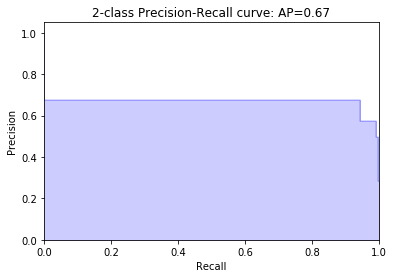

In [45]:
prec_rec_curve(X_test.toarray(), label_test, "proba", clf)
